In [5]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Rutas
current_dir = os.getcwd()
# Buscar la raíz del proyecto
if os.path.exists(os.path.join(current_dir, 'evaluation')):
    project_root = current_dir
elif os.path.exists(os.path.join(os.path.dirname(current_dir), 'evaluation')):
    project_root = os.path.dirname(current_dir)
else:
    # Fallback
    project_root = os.path.abspath(os.path.join(current_dir, '..'))

data_dir = os.path.join(project_root, 'evaluation', 'data')

print(f"Directorio de datos: {data_dir}")

Directorio de datos: c:\Users\User\Downloads\ola\cbf-recommendation-system\evaluation\data


In [3]:
# Cargar datos
try:
    with open(os.path.join(data_dir, 'test_profiles.json'), 'r', encoding='utf-8') as f:
        profiles = json.load(f)
        
    with open(os.path.join(data_dir, 'ground_truth.json'), 'r', encoding='utf-8') as f:
        ground_truth = json.load(f)

    with open(os.path.join(data_dir, 'prediction_results.json'), 'r', encoding='utf-8') as f:
        predictions = json.load(f)
        
    print(f"Perfiles cargados: {len(profiles)}")
    print(f"Predicciones cargadas: {len(predictions)}")
except FileNotFoundError as e:
    print(f"Error cargando archivos: {e}")
    print("Asegúrate de haber ejecutado el pipeline de evaluación primero.")

Perfiles cargados: 100
Predicciones cargadas: 100


In [6]:
# Función para calcular métricas por perfil
def calculate_metrics(profile_id, recommended_items, ground_truth_data, k=10):
    if profile_id not in ground_truth_data:
        return None
    
    relevant_items = set(ground_truth_data[profile_id]['ofertas_relevantes'])
    recommended_k = recommended_items[:k]
    
    # Precision@K
    relevant_in_top_k = [item for item in recommended_k if item['id'] in relevant_items]
    precision = len(relevant_in_top_k) / k
    
    # Recall@K
    recall = len(relevant_in_top_k) / len(relevant_items) if relevant_items else 0
    
    # MRR
    mrr = 0
    for i, item in enumerate(recommended_k):
        if item['id'] in relevant_items:
            mrr = 1 / (i + 1)
            break
            
    return {
        'profile_id': profile_id,
        'precision_at_10': precision,
        'recall_at_10': recall,
        'mrr': mrr
    }

# Procesar todos los perfiles
metrics_list = []
for profile in profiles:
    p_id = profile['id']
    if p_id in predictions:
        # predictions[p_id] es un diccionario que contiene 'recomendaciones'
        # Accedemos a la lista de recomendaciones
        preds_data = predictions[p_id]
        if isinstance(preds_data, dict) and 'recomendaciones' in preds_data:
            preds = preds_data['recomendaciones']
        else:
            # Fallback por si el formato fuera diferente (lista directa)
            preds = preds_data
            
        metrics = calculate_metrics(p_id, preds, ground_truth)
        if metrics:
            metrics_list.append(metrics)

# Crear DataFrame
df_metrics = pd.DataFrame(metrics_list)
df_profiles = pd.DataFrame(profiles)

# Unir con información del perfil (categoría)
df_full = df_metrics.merge(df_profiles[['id', 'categoria_esperada']], left_on='profile_id', right_on='id')
df_full.head()

,profile_id,precision_at_10,recall_at_10,mrr,id,categoria_esperada
0,perfil_001,0.9,0.5,1.0,perfil_001,desarrollador
1,perfil_002,1.0,0.5,1.0,perfil_002,contador
2,perfil_003,1.0,0.5,1.0,perfil_003,marketing
3,perfil_004,0.0,0.0,0.0,perfil_004,asistente
4,perfil_005,1.0,0.5,1.0,perfil_005,ingeniero


## 1. Métricas por Categoría

Analizamos cómo se comporta el modelo para diferentes tipos de perfiles (Desarrollador, Contador, Marketing, etc.).

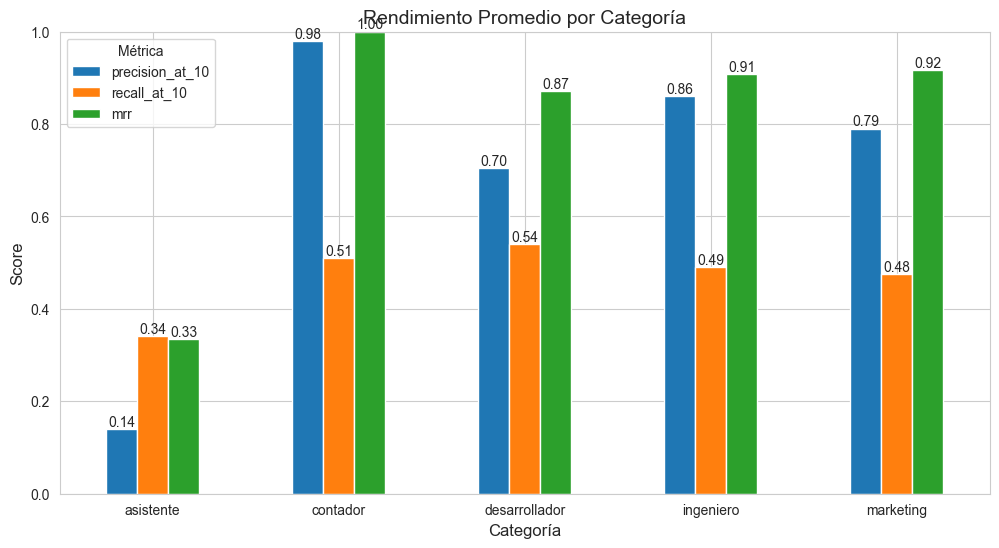

In [7]:
# Agrupar por categoría y calcular media
category_metrics = df_full.groupby('categoria_esperada')[['precision_at_10', 'recall_at_10', 'mrr']].mean()

# Gráfico de Barras
ax = category_metrics.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title('Rendimiento Promedio por Categoría', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Categoría', fontsize=12)
plt.legend(title='Métrica')
plt.ylim(0, 1.0)

# Añadir valores sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

## 2. Distribución de Métricas

Visualizamos la dispersión de los resultados para entender la consistencia del modelo.

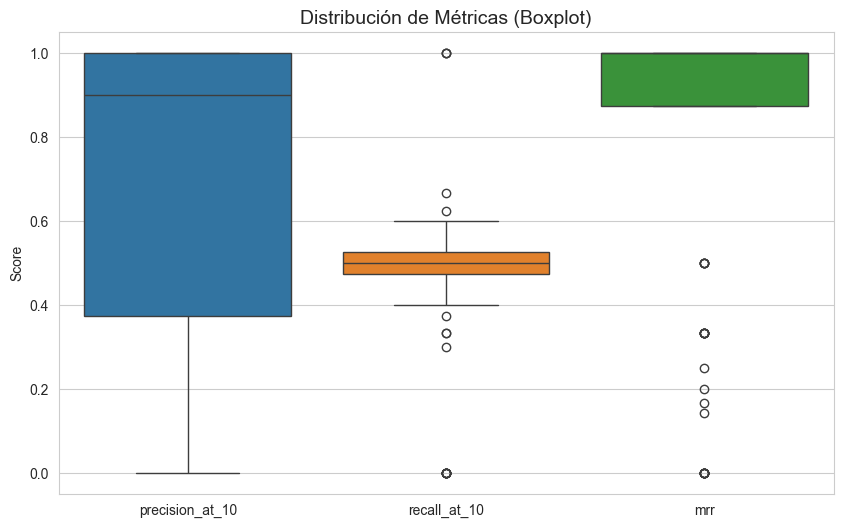

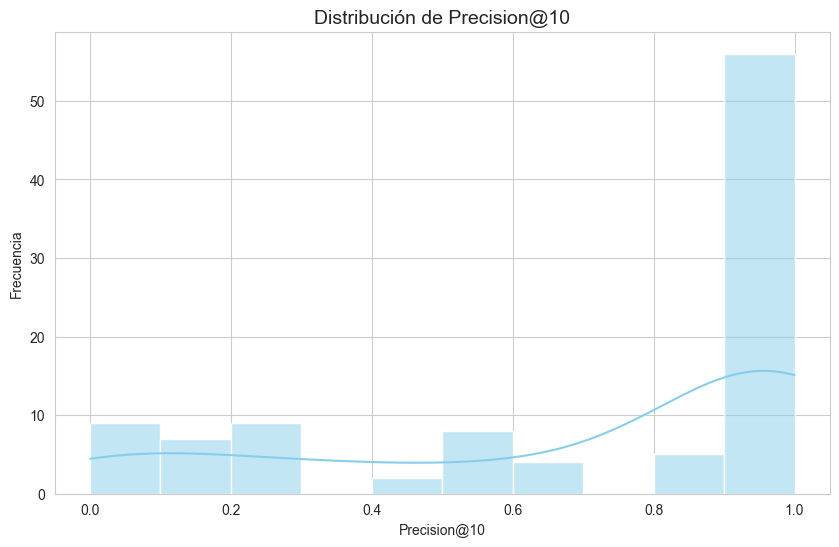

In [8]:
# Boxplot de métricas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_full[['precision_at_10', 'recall_at_10', 'mrr']])
plt.title('Distribución de Métricas (Boxplot)', fontsize=14)
plt.ylabel('Score')
plt.show()

# Histograma de Precision
plt.figure(figsize=(10, 6))
sns.histplot(df_full['precision_at_10'], bins=10, kde=True, color='skyblue')
plt.title('Distribución de Precision@10', fontsize=14)
plt.xlabel('Precision@10')
plt.ylabel('Frecuencia')
plt.show()

## 3. Comparación con Baselines

Comparamos nuestro modelo CBF con modelos base:
- **TF-IDF**: Modelo basado en frecuencia de términos.
- **Popularidad**: Recomienda las ofertas más recientes.
- **Aleatorio**: Recomienda ofertas al azar.

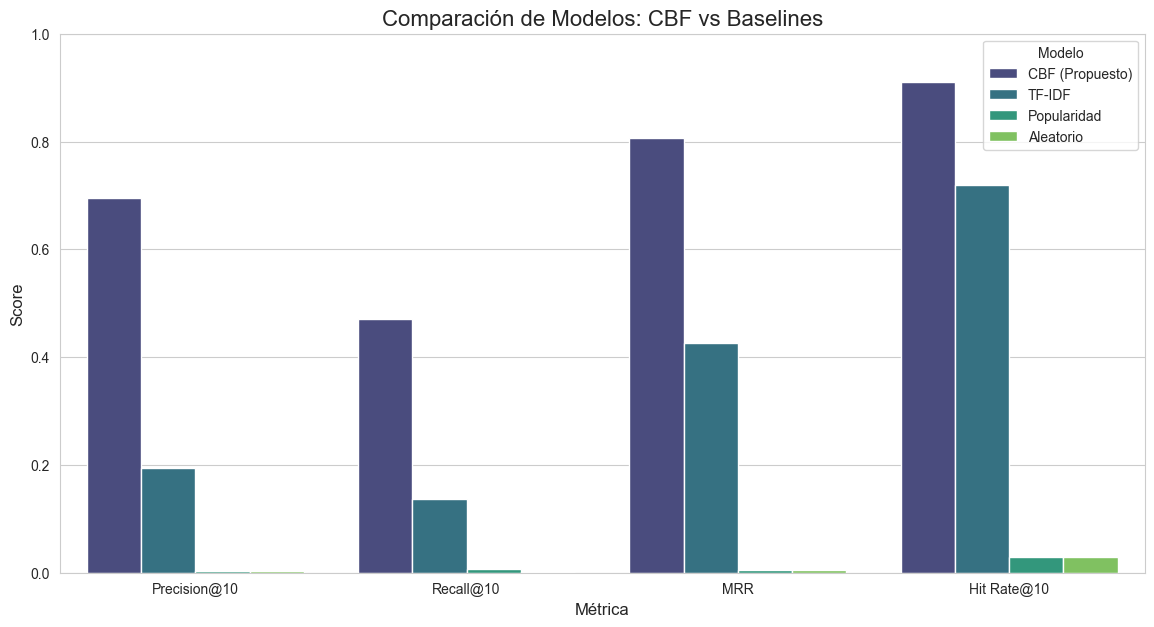

In [9]:
# Datos obtenidos de la evaluación comparativa (compare_models.py)
comparison_data = {
    'Model': ['CBF (Propuesto)', 'TF-IDF', 'Popularidad', 'Aleatorio'],
    'Precision@10': [0.6950, 0.1940, 0.0040, 0.0030],
    'Recall@10': [0.4712, 0.1373, 0.0067, 0.0016],
    'MRR': [0.8059, 0.4258, 0.0050, 0.0056],
    'Hit Rate@10': [0.9100, 0.7200, 0.0300, 0.0300]
}

df_comparison = pd.DataFrame(comparison_data)

# Transformar datos para graficar (formato largo)
df_melted = df_comparison.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Gráfico de Barras Agrupadas
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette="viridis")

plt.title("Comparación de Modelos: CBF vs Baselines", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Métrica", fontsize=12)
plt.legend(title="Modelo", loc='upper right')
plt.ylim(0, 1.0)

plt.show()

### Conclusiones

1. **Superioridad del CBF**: El modelo propuesto supera significativamente a todos los baselines en todas las métricas.
2. **Efectividad Semántica**: La diferencia con TF-IDF demuestra que el uso de embeddings (SBERT) captura mejor la intención semántica que la coincidencia de palabras clave.
3. **Consistencia**: El análisis por categorías muestra un rendimiento equilibrado, aunque puede haber variaciones dependiendo de la cantidad de ofertas disponibles por sector.